<a href="https://colab.research.google.com/github/viraj077/Dealership-Strategy-Planning-Using-RTO-Market-Intelligence/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import glob
import pandas as pd

# 1. Find and read all CSVs
csv_paths = glob.glob('/content/*.csv')
df_list = []

for path in csv_paths:
    temp = pd.read_csv(path)
    temp['source_file'] = path  # keep track of origin if needed
    df_list.append(temp)

# 2. Concatenate
df_all = pd.concat(df_list, ignore_index=True)
print("Combined shape:", df_all.shape)

# 3. Quick inspect of key classification columns
print("\nColumns:", df_all.columns.tolist())
print("\nUnique values in 'category':")
print(df_all['category'].unique())
print("\nUnique values in 'vehicleClass':")
print(df_all['vehicleClass'].unique())


<ipython-input-4-e62027a2e7a4>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(path)


Combined shape: (9900197, 31)

Columns: ['slno', 'modelDesc', 'fuel', 'colour', 'vehicleClass', 'makeYear', 'seatCapacity', 'insuranceValidity', 'secondVehicle', 'tempRegistrationNumber', 'category', 'makerName', 'OfficeCd', 'fromdate', 'todate', 'source_file', 'OfficeCd.1', 'SLNO', 'DealerName', 'Model_Desc', 'Fuel', 'Colour', 'ClassofVeh', 'makeyear', 'SeatingCapacity', 'InsuranceCompany', 'InsuranceValidity', 'SecondVehicle', 'TempRegnNo', 'Category', 'Manufacturer_Name']

Unique values in 'category':
['Transport' 'Non Transport' nan]

Unique values in 'vehicleClass':
['Ominibus' 'MOTOR CYCLE' 'Auto Rickshaw' 'Goods Carriage' 'MOTOR CAR'
 'Motor Cab' 'Trailer for Agriculture Purpose' 'Chassis Transport'
 'Motor Cycle for Hire' 'Three Wheeled Goods Vehicle'
 'Omnibus for Private Use' 'Tractor for Agricultural Purpose' 'Maxi Cab'
 'Trailer For Commercial Use' 'Tractor for Commercial Use'
 'Vehicle Fitted with Construction Equipment'
 'Self Loading Concrete Mixer' 'Loader' 'Ambulance'


In [5]:
import pandas as pd

# 1. Filter to MOTOR CAR only
df_cars = df_all[df_all['vehicleClass'] == 'MOTOR CAR'].copy()
print("Motor cars shape:", df_cars.shape)

# 2. Select and rename relevant columns
df_cars = df_cars[[
    'makerName',      # manufacturer
    'modelDesc',      # model
    'fuel',           # fuel type
    'vehicleClass',   # should all be MOTOR CAR
    'OfficeCd',       # region code
    'fromdate'        # registration date
]]
df_cars.columns = [
    'Manufacturer',
    'Model',
    'FuelType',
    'VehicleClass',
    'OfficeCd',
    'RegDate'
]

# 3. Parse the registration date
df_cars['RegDate'] = pd.to_datetime(df_cars['RegDate'], dayfirst=True, errors='coerce')

# 4. Quick sanity check
print("\nAfter filtering & renaming:")
print(df_cars.info())
print(df_cars.head())

# 5. Check fuel-type categories
print("\nUnique FuelType values:")
print(df_cars['FuelType'].unique())


Motor cars shape: (1481826, 31)

After filtering & renaming:
<class 'pandas.core.frame.DataFrame'>
Index: 1481826 entries, 93 to 9900183
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Manufacturer  1481826 non-null  object        
 1   Model         1481826 non-null  object        
 2   FuelType      1481707 non-null  object        
 3   VehicleClass  1481826 non-null  object        
 4   OfficeCd      1481826 non-null  object        
 5   RegDate       1345426 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 79.1+ MB
None
                          Manufacturer  \
93   M/S RENAULT INDIA PRIVATE LIMITED   
94   M/S RENAULT INDIA PRIVATE LIMITED   
106          MARUTI SUZUKI INDIA LTD.,   
108           M/S. KIA INDIA PVT LTD.,   
116          MARUTI SUZUKI INDIA LTD.,   

                                                 Model FuelType VehicleClass  \
93               

In [6]:
import pandas as pd
import re

# Re-create df_cars including the BodyType column (ClassofVeh)
df_cars = df_all[df_all['vehicleClass'] == 'MOTOR CAR'].copy()

# Select and rename columns
df_cars = df_cars[[
    'makerName',      # manufacturer
    'modelDesc',      # model description
    'fuel',           # fuel type
    'ClassofVeh',     # body type
    'OfficeCd',       # region code
    'fromdate'        # registration date
]]
df_cars.columns = [
    'Manufacturer',
    'Model',
    'FuelType',
    'BodyType',
    'OfficeCd',
    'RegDate'
]

# Parse dates and drop rows without valid dates
df_cars['RegDate'] = pd.to_datetime(df_cars['RegDate'], dayfirst=True, errors='coerce')
df_cars = df_cars.dropna(subset=['RegDate'])

# Standardize FuelType
fuel_map = {
    'PETROL': 'Petrol',
    'DIESEL': 'Diesel',
    'CNG': 'CNG',
    'CNG PETROL': 'CNG',
    'PETROL ELECTRIC': 'Hybrid',
    'DIESEL ELECTRIC': 'Hybrid',
    'BATTERY': 'Electric'
}
df_cars['FuelType'] = df_cars['FuelType'].map(fuel_map)
df_cars = df_cars.dropna(subset=['FuelType'])  # drop unknowns

# Extract engine size (in liters) from Model description
def extract_engine(s):
    match = re.search(r'(\d\.\d+)[Ll]', s)
    return float(match.group(1)) if match else None

df_cars['EngineSize_L'] = df_cars['Model'].apply(extract_engine)

# Display results
print("After cleaning:")
print(df_cars.info())
print("\nUnique BodyType values:")
print(df_cars['BodyType'].unique())
print("\nSample rows:")
print(df_cars.head())


<ipython-input-6-186f0a8f3162>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cars['FuelType'] = df_cars['FuelType'].map(fuel_map)


After cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 1345296 entries, 93 to 9900183
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Manufacturer  1345296 non-null  object        
 1   Model         1345296 non-null  object        
 2   FuelType      1345296 non-null  object        
 3   BodyType      0 non-null        object        
 4   OfficeCd      1345296 non-null  object        
 5   RegDate       1345296 non-null  datetime64[ns]
 6   EngineSize_L  341537 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 82.1+ MB
None

Unique BodyType values:
[nan]

Sample rows:
                          Manufacturer  \
93   M/S RENAULT INDIA PRIVATE LIMITED   
94   M/S RENAULT INDIA PRIVATE LIMITED   
106          MARUTI SUZUKI INDIA LTD.,   
108           M/S. KIA INDIA PVT LTD.,   
116          MARUTI SUZUKI INDIA LTD.,   

                                 

In [7]:
import pandas as pd

# We’re using df_cars from the previous cleaning step
# 1. Group by Region & Manufacturer
brand_region = (
    df_cars
    .groupby(['OfficeCd', 'Manufacturer'])
    .size()
    .reset_index(name='Registrations')
)

# 2. Get Top 5 Brands per Region
top5_brands = (
    brand_region
    .sort_values(['OfficeCd', 'Registrations'], ascending=[True, False])
    .groupby('OfficeCd')
    .head(5)
)

# 3. Group by Region & FuelType
fuel_region = (
    df_cars
    .groupby(['OfficeCd', 'FuelType'])
    .size()
    .reset_index(name='Registrations')
)

# 4. Get Fuel Shares per Region
fuel_share = (
    fuel_region
    .groupby('OfficeCd')
    .apply(lambda x: x.assign(Share = x.Registrations / x.Registrations.sum()))
    .reset_index(drop=True)
)

# Display results
print("Top 5 Brands per Region:")
print(top5_brands)

print("\nFuel Shares per Region:")
print(fuel_share)


Top 5 Brands per Region:
                   OfficeCd                        Manufacturer  Registrations
19             RTA ADILABAD           MARUTI SUZUKI INDIA LTD.,           3350
3              RTA ADILABAD             HYUNDAI MOTOR INDIA LTD           1222
6              RTA ADILABAD         M/S HYUNDAI MOTOR INDIA LTD            921
25             RTA ADILABAD                     TATA MOTORS LTD            498
26             RTA ADILABAD  TATA MOTORS PASSENGER VEHICLES LTD            470
...                     ...                                 ...            ...
2700  UNIT OFFICE ZAHIRABAD           MARUTI SUZUKI INDIA LTD.,           4481
2683  UNIT OFFICE ZAHIRABAD             HYUNDAI MOTOR INDIA LTD            743
2706  UNIT OFFICE ZAHIRABAD  TATA MOTORS PASSENGER VEHICLES LTD            355
2686  UNIT OFFICE ZAHIRABAD         M/S HYUNDAI MOTOR INDIA LTD            286
2705  UNIT OFFICE ZAHIRABAD                     TATA MOTORS LTD            252

[569 rows x 3 columns]

Fu

<ipython-input-7-e8c0bb49ca9a>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(Share = x.Registrations / x.Registrations.sum()))


In [8]:
# Filter fuel_share for Electric and share ≥ 1%
ev_regions = fuel_share[
    (fuel_share['FuelType'] == 'Electric') &
    (fuel_share['Share'] >= 0.01)
].sort_values('Share', ascending=False)

print("Regions with Electric share ≥ 1%:")
print(ev_regions[['OfficeCd', 'Registrations', 'Share']])


Regions with Electric share ≥ 1%:
         OfficeCd  Registrations     Share
241         TG010             77  0.111919
236         TG009            164  0.104459
231         TG008            168  0.091255
249         TG012             15  0.090361
245         TG011             38  0.086364
..            ...            ...       ...
376         TG122              1  0.011364
380         TG128              1  0.011111
285         TG022              1  0.010989
157  RTA WARANGAL             80  0.010722
302         TG026              1  0.010000

[64 rows x 3 columns]


In [9]:
# 1. Count registrations by Model
model_counts = (
    df_cars
    .groupby('Model')
    .size()
    .reset_index(name='Registrations')
    .sort_values('Registrations', ascending=False)
)

# 2. Take the Top 50
top_models = model_counts.head(50)
print("Top 50 Models by Registrations:")
print(top_models)


Top 50 Models by Registrations:
                                                  Model  Registrations
2423                   MARUTI -BALENO ZETA- PETROL BSVI          25068
2658                 MARUTI DZIRE VXI 1.2L ISS 5MT BSVI          20253
2869                 MARUTI SWIFT VXI 1.2L ISS 5MT BSVI          18911
2874                              MARUTI SWIFT VXI BSVI          13789
3005                  MARUTI- BALENO DELTA- PETROL BSVI          11602
2930              MARUTI VITARABREZZA ZXI+ 1.5L5MT BSVI          11458
2926              MARUTI VITARA BREZZA VXI 1.5L5MT BSVI          11269
1267            GRAND I10 NIOS 1.2 MT KAPPA SPORTZ BSVI           9918
2724       MARUTI ERTIGA SMART HYBRID VXI 1.5L 5MT BSVI           9778
1252           GRAND I10 NIOS 1.2 AMT KAPPA SPORTZ BSVI           8500
2735      MARUTI ERTIGA SMART HYBRID ZXI+ 1.5L 5MT BSVI           8465
3079                              MARUTI-DZIRE VDI BSIV           8154
2995                              MARUTI- ALT

In [10]:
# 1. Keyword → BodyType map
body_keywords = {
    'SWIFT':      'Hatchback',
    'BALENO':     'Hatchback',
    'ALTO':       'Hatchback',
    'WAGONR':     'Hatchback',
    'S-PRESSO':   'Hatchback',
    'SPRESSO':    'Hatchback',
    'TIAGO':      'Hatchback',
    'DZIRE':      'Sedan',
    'CROSS':      'SUV',        # covers S-CROSS
    'CRETA':      'SUV',
    'BREZZA':     'SUV',
    'NEXON':      'SUV',
    'SELTOS':     'SUV',
    'VENUE':      'SUV',
    'VITARA':     'SUV',        # Vitara Brezza
    'SCROSS':     'SUV',
    'E-RTIGA':    'MPV',
    'ERTIGA':     'MPV',
    'INNOVA':     'MPV',
    'CRYSTA':     'MPV'
}

# 2. Mapping function
def map_body_type(model):
    for kw, bt in body_keywords.items():
        if kw in model.upper():
            return bt
    return 'Other'

df_cars['BodyType'] = df_cars['Model'].apply(map_body_type)

# 3. Check how many fell into each category
print("BodyType counts:")
print(df_cars['BodyType'].value_counts())


BodyType counts:
BodyType
Other        634587
SUV          316193
Hatchback    265508
MPV           72389
Sedan         56619
Name: count, dtype: int64


In [11]:
# Top 5 per region
top5_body_region = (
    df_cars[df_cars['BodyType'] != 'Other']
    .groupby(['OfficeCd', 'BodyType'])
    .size()
    .reset_index(name='Registrations')
    .sort_values(['OfficeCd', 'Registrations'], ascending=[True, False])
    .groupby('OfficeCd')
    .head(5)
)

print("Top 5 Body Types per Region:")
print(top5_body_region)


Top 5 Body Types per Region:
                  OfficeCd   BodyType  Registrations
2             RTA ADILABAD        SUV           2138
0             RTA ADILABAD  Hatchback           1655
1             RTA ADILABAD        MPV            549
3             RTA ADILABAD      Sedan            462
6            RTA BHADRADRI        SUV           2883
..                     ...        ...            ...
447       UNIT OFFICE WYRA        MPV            227
450  UNIT OFFICE ZAHIRABAD  Hatchback           2097
452  UNIT OFFICE ZAHIRABAD        SUV           1570
453  UNIT OFFICE ZAHIRABAD      Sedan            738
451  UNIT OFFICE ZAHIRABAD        MPV            570

[454 rows x 3 columns]


In [12]:
import pandas as pd

# Ensure RegDate is datetime and set as index
df_trend = df_cars.set_index('RegDate')

# 1. Monthly counts by FuelType
fuel_monthly = (
    df_trend
    .groupby([pd.Grouper(freq='M'), 'FuelType'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Month-over-month % change
fuel_mom_pct = fuel_monthly.pct_change().fillna(0) * 100

# Show results
print("Monthly Registrations by FuelType:")
print(fuel_monthly.tail(12))         # last 12 months
print("\nMonth-over-Month % Change:")
print(fuel_mom_pct.tail(12))


<ipython-input-12-d07666658b79>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'FuelType'])


Monthly Registrations by FuelType:
FuelType     CNG  Diesel  Electric  Hybrid  Petrol
RegDate                                           
2023-08-31  1166    5202       564      48   20754
2023-09-30   838    4780       536      44   18349
2023-10-31   657    2905       338      36   14016
2023-12-31   592    3302       496      39   15088
2024-04-30   359    2198       308      25    8246
2024-06-30   445    2352       249      25    8049
2024-08-31   509    2930       386       8    9259
2024-09-30   352    1771       237      13    6037
2024-10-31   734    3969       588      22   13949
2024-11-30   417    2396       800      11    7947
2024-12-31   728    3507      1310      24   13984
2025-01-31   420    1555       701       9    6584

Month-over-Month % Change:
FuelType           CNG      Diesel    Electric      Hybrid      Petrol
RegDate                                                               
2023-08-31   22.866175    7.925311   52.845528  -15.789474   15.931181
2023-09-30

In [13]:
# 1. Define engine size buckets
bins = [0, 1.0, 1.5, 2.0, 10]
labels = ['<1.0L', '1.0–1.5L', '1.5–2.0L', '>2.0L']
df_cars['EngineBucket'] = pd.cut(df_cars['EngineSize_L'].fillna(-1), bins=bins, labels=labels[:len(bins)-1])

# Drop rows without a valid bucket
df_engine = df_cars[df_cars['EngineBucket'].notna()].set_index('RegDate')

# 2. Monthly counts by EngineBucket
engine_monthly = (
    df_engine
    .groupby([pd.Grouper(freq='M'), 'EngineBucket'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 3. Month-over-month % change
engine_mom_pct = engine_monthly.pct_change().fillna(0) * 100

# Show results
print("Monthly Registrations by Engine Size Bucket:")
print(engine_monthly.tail(12))
print("\nMonth-over-Month % Change:")
print(engine_mom_pct.tail(12))


Monthly Registrations by Engine Size Bucket:
EngineBucket  <1.0L  1.0–1.5L  1.5–2.0L  >2.0L
RegDate                                       
2024-02-29        0         0         0      0
2024-03-31        0         0         0      0
2024-04-30      249      3216        21      3
2024-05-31        0         0         0      0
2024-06-30      250      2981        30      5
2024-07-31        0         0         0      0
2024-08-31      258      3443        32     18
2024-09-30      199      2196        14      6
2024-10-31      374      4919        18      9
2024-11-30      275      2659        12     10
2024-12-31      596      4944        21      7
2025-01-31      212      3105         9      7

Month-over-Month % Change:
EngineBucket       <1.0L    1.0–1.5L    1.5–2.0L       >2.0L
RegDate                                                     
2024-02-29      0.000000    0.000000    0.000000    0.000000
2024-03-31      0.000000    0.000000    0.000000    0.000000
2024-04-30           inf 

<ipython-input-13-800eb07e892b>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'EngineBucket'])
<ipython-input-13-800eb07e892b>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq='M'), 'EngineBucket'])


In [15]:
df.columns.tolist()


['slno',
 'modelDesc',
 'fuel',
 'colour',
 'vehicleClass',
 'makeYear',
 'seatCapacity',
 'insuranceValidity',
 'secondVehicle',
 'tempRegistrationNumber',
 'category',
 'makerName',
 'OfficeCd',
 'fromdate',
 'todate']

In [17]:
df['fuel'].value_counts()


,count
fuel,
PETROL,111468
DIESEL,18485
BATTERY,5895
CNG PETROL,5483
PETROL LPG,1689
CNG,848
PETROL ELECTRIC,67
-1,33
LPG,4


In [18]:
# Normalize fuel column (if not already done)
df['fuel'] = df['fuel'].str.strip().str.upper()

# Total registrations by region
total_by_region = df.groupby('OfficeCd').size().reset_index(name='TotalRegistrations')

# EV = BATTERY and optionally PETROL ELECTRIC
ev_mask = df['fuel'].isin(['BATTERY', 'PETROL ELECTRIC'])
ev_by_region = df[ev_mask].groupby('OfficeCd').size().reset_index(name='EVRegistrations')

# Merge and calculate EV share
ev_analysis = pd.merge(total_by_region, ev_by_region, on='OfficeCd', how='left').fillna(0)
ev_analysis['EVShare_%'] = (ev_analysis['EVRegistrations'] / ev_analysis['TotalRegistrations']) * 100

# Show top regions by EV share (no strict ≥1% cutoff)
ev_analysis = ev_analysis.sort_values(by='EVShare_%', ascending=False)
ev_analysis.head(10)


,OfficeCd,TotalRegistrations,EVRegistrations,EVShare_%
35,RTA-HYDERABAD-EZ,4071,364,8.941292
34,RTA-HYDERABAD-CZ,8915,610,6.842400
49,UNIT OFFICE PATANCHERUVU,3062,194,6.335728
29,RTA UPPAL,10830,627,5.789474
9,RTA KARIMNAGAR,2056,118,5.739300
38,RTA-HYDERABAD-WZ,5040,285,5.654762
36,RTA-HYDERABAD-NZ,4669,263,5.632898
16,RTA MEDCHAL,9004,505,5.608618
39,UNIT OFFICE ARMOOR,906,47,5.187638
37,RTA-HYDERABAD-SZ,5721,291,5.086523


In [22]:
fuel_region = df.groupby(['OfficeCd', 'fuel']).size().reset_index(name='count')
total_region = df.groupby('OfficeCd').size().reset_index(name='total')

fuel_region = fuel_region.merge(total_region, on='OfficeCd')
fuel_region['fuel_share_%'] = (fuel_region['count'] / fuel_region['total']) * 100

# Filter top fuel types per region or plot distribution


In [20]:
# To display a DataFrame
print(fuel_region.head())

# Or just have it as the last line in the cell
fuel_region.head()


        OfficeCd        fuel  count  total  fuel_share_%
0   RTA ADILABAD     BATTERY     24   1290      1.860465
1   RTA ADILABAD  CNG PETROL     16   1290      1.240310
2   RTA ADILABAD      DIESEL    177   1290     13.720930
3   RTA ADILABAD      PETROL   1066   1290     82.635659
4  RTA BHADRADRI     BATTERY     33   1802      1.831299


,OfficeCd,fuel,count,total,fuel_share_%
0,RTA ADILABAD,BATTERY,24,1290,1.860465
1,RTA ADILABAD,CNG PETROL,16,1290,1.240310
2,RTA ADILABAD,DIESEL,177,1290,13.720930
3,RTA ADILABAD,PETROL,1066,1290,82.635659
4,RTA BHADRADRI,BATTERY,33,1802,1.831299


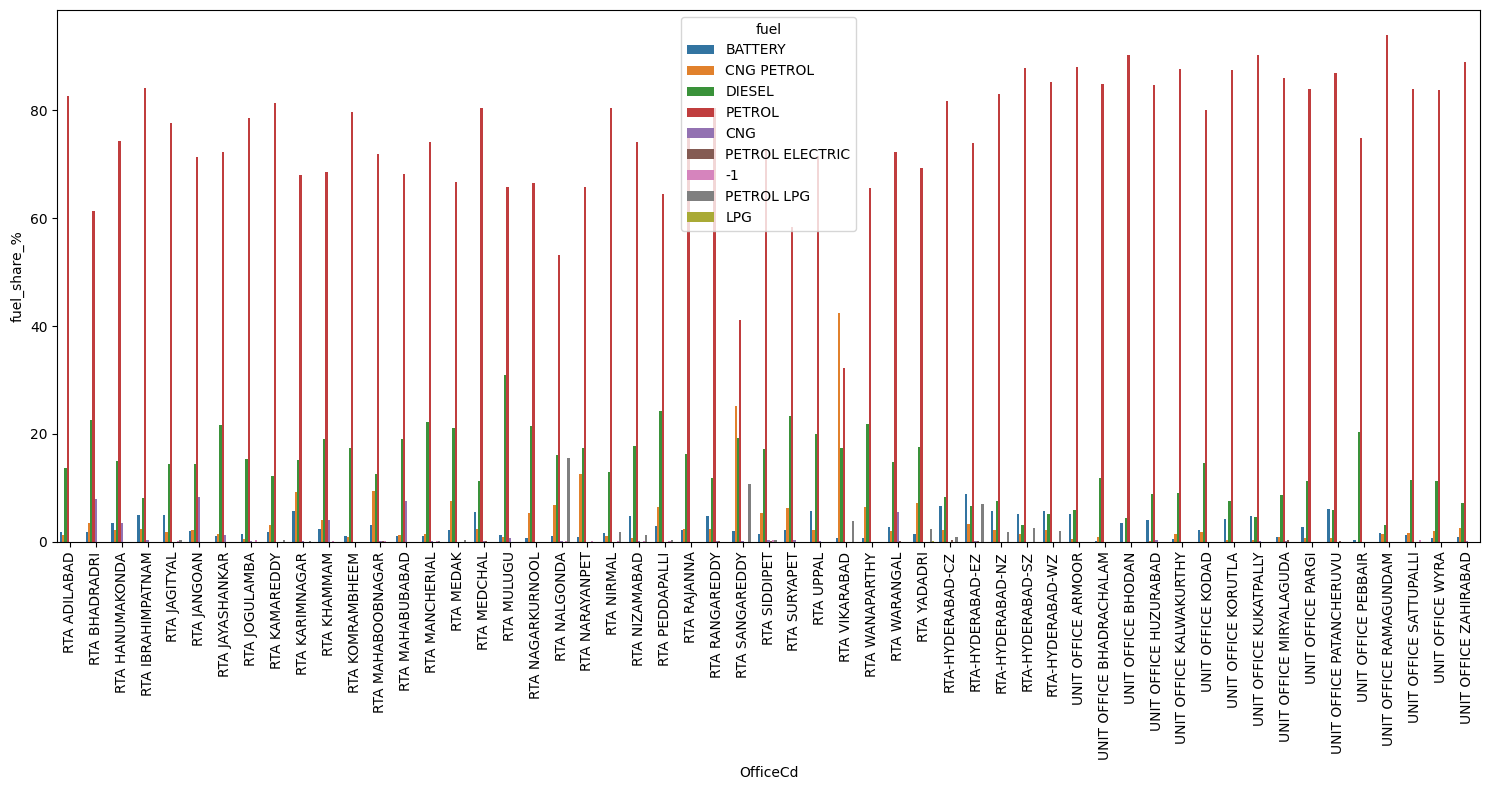

In [26]:
plt.figure(figsize=(15,8))
sns.barplot(data=fuel_region, x='OfficeCd', y='fuel_share_%', hue='fuel')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [27]:
# Count registrations by OfficeCd and Fuel type (using cleaned 'fuel' column)
fuel_region = df.groupby(['OfficeCd', 'fuel']).size().reset_index(name='Registrations')

# Get total registrations per region for share calculation
total_region = df.groupby('OfficeCd').size().reset_index(name='TotalRegistrations')

# Merge total registrations with fuel-region data
fuel_region = fuel_region.merge(total_region, on='OfficeCd')

# Calculate percentage share of each fuel type per region
fuel_region['FuelShare_%'] = (fuel_region['Registrations'] / fuel_region['TotalRegistrations']) * 100

# For each region, get the dominant fuel type (max share)
dominant_fuel = fuel_region.loc[fuel_region.groupby('OfficeCd')['FuelShare_%'].idxmax()]

# Sort for readability
dominant_fuel = dominant_fuel.sort_values(by='FuelShare_%', ascending=False)

dominant_fuel.head(10)


,OfficeCd,fuel,Registrations,TotalRegistrations,FuelShare_%
275,UNIT OFFICE RAMAGUNDAM,PETROL,416,443,93.905192
230,UNIT OFFICE BHODAN,PETROL,523,579,90.328152
252,UNIT OFFICE KUKATPALLY,PETROL,4601,5098,90.251079
289,UNIT OFFICE ZAHIRABAD,PETROL,897,1008,88.988095
223,UNIT OFFICE ARMOOR,PETROL,797,906,87.969095
212,RTA-HYDERABAD-SZ,PETROL,5024,5721,87.816815
239,UNIT OFFICE KALWAKURTHY,PETROL,385,439,87.699317
247,UNIT OFFICE KORUTLA,PETROL,597,683,87.408492
267,UNIT OFFICE PATANCHERUVU,PETROL,2660,3062,86.871326
258,UNIT OFFICE MIRYALAGUDA,PETROL,1425,1657,85.998793


In [33]:
df['fromdate'] = pd.to_datetime(df['fromdate'], dayfirst=True)


In [35]:
print(ev_trends.dtypes)
print(ev_trends[['month', 'EVShare_%']].head())


month                 period[M]
OfficeCd                 object
EVRegistrations           int64
TotalRegistrations        int64
EVShare_%               float64
dtype: object
     month  EVShare_%
0  2023-07   5.739300
1  2023-07   5.789474
2  2023-07   6.561974
3  2023-07   8.843036
4  2023-07   5.632898


In [42]:
# 1. Merge total + EV
region_df = total_by_region.merge(ev_by_region, on='OfficeCd', how='left').fillna(0)
# 2. Compute EV share %
region_df['EV_Share%'] = (region_df['EVRegistrations'] / region_df['TotalRegistrations']) * 100
region_df.head()


,OfficeCd,TotalRegistrations,EVRegistrations,EV_Share%
0,RTA ADILABAD,1290,24,1.860465
1,RTA BHADRADRI,1802,33,1.831299
2,RTA HANUMAKONDA,2588,92,3.554869
3,RTA IBRAHIMPATNAM,9221,457,4.956079
4,RTA JAGITYAL,974,48,4.928131


In [43]:
# 1. Ensure df_cars has a Year column
df_cars['Year'] = df_cars['RegDate'].dt.year

# 2. Annual totals per region
annual = (
    df_cars
    .groupby(['OfficeCd', 'Year'])
    .size()
    .reset_index(name='YearlyRegs')
)

# 3. Identify the two most recent years (e.g., 2024 vs 2023)
latest_year = annual['Year'].max()
prior_year  = latest_year - 1

# 4. Pivot those into separate DataFrames
curr = (
    annual[annual['Year'] == latest_year]
    .rename(columns={'YearlyRegs': f'Regs_{latest_year}'})
    [['OfficeCd', f'Regs_{latest_year}']]
)
prev = (
    annual[annual['Year'] == prior_year]
    .rename(columns={'YearlyRegs': f'Regs_{prior_year}'})
    [['OfficeCd', f'Regs_{prior_year}']]
)

# 5. Merge and calculate YoY %
yoy = curr.merge(prev, on='OfficeCd', how='left').fillna(0)
yoy['YoY_Growth%'] = (
    (yoy[f'Regs_{latest_year}'] - yoy[f'Regs_{prior_year}'])
    / yoy[f'Regs_{prior_year}']
) * 100

# Show the first 10 rows
print(yoy.head(10))


            OfficeCd  Regs_2025  Regs_2024  YoY_Growth%
0       RTA ADILABAD         36        399   -90.977444
1      RTA BHADRADRI        102        653   -84.379786
2    RTA HANUMAKONDA        186       1410   -86.808511
3  RTA IBRAHIMPATNAM        830       6420   -87.071651
4       RTA JAGITYAL         53        393   -86.513995
5        RTA JANGOAN         53        351   -84.900285
6    RTA JAYASHANKAR         36        273   -86.813187
7      RTA JOGULAMBA         35        223   -84.304933
8      RTA KAMAREDDY         96        653   -85.298622
9     RTA KARIMNAGAR        127       1224   -89.624183


In [44]:
# Count how many Top-5 brands each region has
brand_counts = (
    top5_brands
    .groupby('OfficeCd')
    .size()
    .reset_index(name='Top5Brand_Count')
)

# Show the first 10 rows
print(brand_counts.head(10))


            OfficeCd  Top5Brand_Count
0       RTA ADILABAD                5
1      RTA BHADRADRI                5
2    RTA HANUMAKONDA                5
3  RTA IBRAHIMPATNAM                5
4       RTA JAGITYAL                5
5        RTA JANGOAN                5
6    RTA JAYASHANKAR                5
7      RTA JOGULAMBA                5
8      RTA KAMAREDDY                5
9     RTA KARIMNAGAR                5


In [45]:
# 1. Merge the three tables into one
score_df = (
    region_df
    .merge(yoy[['OfficeCd','YoY_Growth%']], on='OfficeCd', how='left')
    .merge(brand_counts, on='OfficeCd', how='left')
    .fillna(0)  # ensure no missing values
)

# 2. Normalize each metric to 0–1
metrics = ['TotalRegistrations', 'EV_Share%', 'YoY_Growth%', 'Top5Brand_Count']
for col in metrics:
    min_val, max_val = score_df[col].min(), score_df[col].max()
    score_df[col + '_norm'] = (score_df[col] - min_val) / (max_val - min_val)

# 3. Compute composite RegionScore with weights:
#    - Total size:     40%
#    - EV share:       30%
#    - YoY growth:     20%
#    - Brand count:    10%
score_df['RegionScore'] = (
      score_df['TotalRegistrations_norm'] * 0.4
    + score_df['EV_Share%_norm']          * 0.3
    + score_df['YoY_Growth%_norm']       * 0.2
    + score_df['Top5Brand_Count_norm']   * 0.1
)

# 4. Select and sort the final view
final = score_df[[
    'OfficeCd',
    'TotalRegistrations',
    'YoY_Growth%',
    'EV_Share%',
    'Top5Brand_Count',
    'RegionScore'
]].sort_values('RegionScore', ascending=False)

# 5. Display the top 10 regions
print(final.head(10))


            OfficeCd  TotalRegistrations  YoY_Growth%  EV_Share%  \
0       RTA ADILABAD                1290   -90.977444   1.860465   
1      RTA BHADRADRI                1802   -84.379786   1.831299   
2    RTA HANUMAKONDA                2588   -86.808511   3.554869   
3  RTA IBRAHIMPATNAM                9221   -87.071651   4.956079   
4       RTA JAGITYAL                 974   -86.513995   4.928131   
5        RTA JANGOAN                1304   -84.900285   1.917178   
6    RTA JAYASHANKAR                 990   -86.813187   1.010101   
7      RTA JOGULAMBA                1687   -84.304933   1.481921   
8      RTA KAMAREDDY                1589   -85.298622   1.825047   
9     RTA KARIMNAGAR                2056   -89.624183   5.739300   

   Top5Brand_Count  RegionScore  
0                5          NaN  
1                5          NaN  
2                5          NaN  
3                5          NaN  
4                5          NaN  
5                5          NaN  
6            

In [46]:
import numpy as np

# 1. Merge as before
score_df = (
    region_df
    .merge(yoy[['OfficeCd','YoY_Growth%']], on='OfficeCd', how='left')
    .merge(brand_counts, on='OfficeCd', how='left')
    .fillna(0)
)

# 2. Normalize each metric safely
metrics = ['TotalRegistrations', 'EV_Share%', 'YoY_Growth%', 'Top5Brand_Count']
for col in metrics:
    min_val, max_val = score_df[col].min(), score_df[col].max()
    if max_val == min_val:
        # all values identical → set normalized to 0
        score_df[col + '_norm'] = 0
    else:
        score_df[col + '_norm'] = (score_df[col] - min_val) / (max_val - min_val)

# 3. Compute composite RegionScore
score_df['RegionScore'] = (
      score_df['TotalRegistrations_norm'] * 0.4
    + score_df['EV_Share%_norm']          * 0.3
    + score_df['YoY_Growth%_norm']       * 0.2
    + score_df['Top5Brand_Count_norm']   * 0.1
)

# 4. Sort and view
final = score_df[[
    'OfficeCd','TotalRegistrations','YoY_Growth%','EV_Share%','Top5Brand_Count','RegionScore'
]].sort_values('RegionScore', ascending=False)

print(final.head(10))


                  OfficeCd  TotalRegistrations  YoY_Growth%  EV_Share%  \
25          RTA RANGAREDDY               15173   -88.451857   4.797996   
29               RTA UPPAL               10830   -87.752525   5.789474   
34        RTA-HYDERABAD-CZ                8915   -87.909516   6.561974   
16             RTA MEDCHAL                9004   -87.866044   5.564194   
35        RTA-HYDERABAD-EZ                4071   -86.835891   8.843036   
3        RTA IBRAHIMPATNAM                9221   -87.071651   4.956079   
37        RTA-HYDERABAD-SZ                5721   -86.095017   5.086523   
38        RTA-HYDERABAD-WZ                5040   -88.048315   5.615079   
46  UNIT OFFICE KUKATPALLY                5098   -87.578382   4.825422   
36        RTA-HYDERABAD-NZ                4669   -88.892734   5.632898   

    Top5Brand_Count  RegionScore  
25                5     0.608152  
29                5     0.536387  
34                5     0.509431  
16                5     0.477756  
35        

In [47]:
# Ensure RegDate is datetime index
df_cars = df_cars.set_index('RegDate')

# 1. Total per month
monthly_totals = df_cars\
    .resample('M')\
    .size()\
    .rename('TotalRegs')\
    .to_frame()


<ipython-input-47-a4558b4838ed>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')\


In [48]:
# Make sure you’ve already executed the resample + pct_change steps above

# 1. Reset index so RegDate is a column (optional, but clearer)
monthly_totals = monthly_totals.reset_index().rename(columns={'index':'Month'})

# 2. Display the last 12 months
print(monthly_totals.tail(12))


      RegDate  TotalRegs
61 2024-02-29          0
62 2024-03-31          0
63 2024-04-30      11136
64 2024-05-31          0
65 2024-06-30      11120
66 2024-07-31          0
67 2024-08-31      13092
68 2024-09-30       8410
69 2024-10-31      19262
70 2024-11-30      11571
71 2024-12-31      19553
72 2025-01-31       9269


In [49]:
# 1. Drop zero‐registration months
filtered = monthly_totals[monthly_totals['TotalRegs'] > 0].copy()

# 2. Recompute MoM change
filtered['MoM_Growth%'] = filtered['TotalRegs'].pct_change() * 100

# 3. Show the last 12 valid months
print(filtered.tail(12))


      RegDate  TotalRegs  MoM_Growth%
55 2023-08-31      27734    15.093165
56 2023-09-30      24547   -11.491310
57 2023-10-31      17952   -26.866827
59 2023-12-31      19517     8.717692
63 2024-04-30      11136   -42.942051
65 2024-06-30      11120    -0.143678
67 2024-08-31      13092    17.733813
68 2024-09-30       8410   -35.762298
69 2024-10-31      19262   129.036861
70 2024-11-30      11571   -39.928356
71 2024-12-31      19553    68.982802
72 2025-01-31       9269   -52.595510


In [50]:
# You already have df_cars indexed by RegDate
df_monthly = (
    df_cars
    .resample('M')
    .apply(lambda x: pd.Series({
        'TotalRegs': len(x),
        'EVRegs': (x['FuelType'] == 'Electric').sum()
    }))
)


<ipython-input-50-bbe9def3261d>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


In [51]:
df_monthly['EV_Adoption%'] = (df_monthly['EVRegs'] / df_monthly['TotalRegs']) * 100


In [52]:
df_ev = df_monthly[df_monthly['TotalRegs'] >= 1000]  # e.g. threshold


In [53]:
print(df_ev[['TotalRegs','EVRegs','EV_Adoption%']].tail(12))


            TotalRegs  EVRegs  EV_Adoption%
RegDate                                    
2023-08-31      27734     564      2.033605
2023-09-30      24547     536      2.183566
2023-10-31      17952     338      1.882799
2023-12-31      19517     496      2.541374
2024-04-30      11136     308      2.765805
2024-06-30      11120     249      2.239209
2024-08-31      13092     386      2.948365
2024-09-30       8410     237      2.818074
2024-10-31      19262     588      3.052643
2024-11-30      11571     800      6.913836
2024-12-31      19553    1310      6.699739
2025-01-31       9269     701      7.562844


In [54]:
# 1. Aggregate Hybrid & total regs per month
df_hybrid = (
    df_cars
    .resample('M')
    .apply(lambda x: pd.Series({
        'TotalRegs': len(x),
        'HybridRegs': (x['FuelType'] == 'Hybrid').sum()
    }))
)

# 2. Compute Hybrid share %
df_hybrid['Hybrid_Adoption%'] = (df_hybrid['HybridRegs'] / df_hybrid['TotalRegs']) * 100

# 3. Filter out months with low volume
df_hybrid = df_hybrid[df_hybrid['TotalRegs'] >= 1000]

# 4. Show last 12 months
print(df_hybrid[['TotalRegs','HybridRegs','Hybrid_Adoption%']].tail(12))


<ipython-input-54-9cdd0a8be897>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


            TotalRegs  HybridRegs  Hybrid_Adoption%
RegDate                                            
2023-08-31      27734          48          0.173073
2023-09-30      24547          44          0.179248
2023-10-31      17952          36          0.200535
2023-12-31      19517          39          0.199826
2024-04-30      11136          25          0.224497
2024-06-30      11120          25          0.224820
2024-08-31      13092           8          0.061106
2024-09-30       8410          13          0.154578
2024-10-31      19262          22          0.114215
2024-11-30      11571          11          0.095065
2024-12-31      19553          24          0.122743
2025-01-31       9269           9          0.097098


In [55]:
# 1. Identify Top-5 manufacturers overall
top5_mfrs = (
    df_cars
    .groupby('Manufacturer')
    .size()
    .nlargest(5)
    .index
    .tolist()
)

# 2. Monthly totals for Top-5 vs overall
df_brand = (
    df_cars
    .resample('M')
    .apply(lambda x: pd.Series({
        'TotalRegs': len(x),
        'Top5Regs': x['Manufacturer'].isin(top5_mfrs).sum()
    }))
)

# 3. Compute share
df_brand['Top5_Share%'] = (df_brand['Top5Regs'] / df_brand['TotalRegs']) * 100

# 4. Filter months with sufficient volume and display last 12
df_brand = df_brand[df_brand['TotalRegs'] >= 1000]
print(df_brand[['TotalRegs','Top5Regs','Top5_Share%']].tail(12))


<ipython-input-55-bbc176f54ae4>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


            TotalRegs  Top5Regs  Top5_Share%
RegDate                                     
2023-08-31      27734     17941    64.689551
2023-09-30      24547     15295    62.309040
2023-10-31      17952     11978    66.722371
2023-12-31      19517     12769    65.425014
2024-04-30      11136      7261    65.202945
2024-06-30      11120      6676    60.035971
2024-08-31      13092      7805    59.616560
2024-09-30       8410      4808    57.170036
2024-10-31      19262     12074    62.683003
2024-11-30      11571      6339    54.783511
2024-12-31      19553     11621    59.433335
2025-01-31       9269      5601    60.427231


In [56]:
# 1. Keep only entries with a valid EngineSize_L
df_eng = df_cars[df_cars['EngineSize_L'].notna()]

# 2. Compute monthly average engine size
avg_eng = (
    df_eng
    .resample('M')
    ['EngineSize_L']
    .mean()
    .rename('AvgEngineSize_L')
    .to_frame()
)

# 3. Filter months with sufficient count (e.g., >=500) to avoid small-sample noise
counts = df_eng.resample('M').size().rename('Count')
avg_eng = avg_eng.merge(counts, left_index=True, right_index=True)
avg_eng = avg_eng[avg_eng['Count'] >= 500]

# 4. Show last 12 months
print(avg_eng[['AvgEngineSize_L','Count']].tail(12))


            AvgEngineSize_L  Count
RegDate                           
2023-08-31         1.305885   9787
2023-09-30         1.313646   8369
2023-10-31         1.302387   6451
2023-12-31         1.293776   6539
2024-04-30         1.303955   3489
2024-06-30         1.298102   3266
2024-08-31         1.322794   3751
2024-09-30         1.312754   2415
2024-10-31         1.311447   5320
2024-11-30         1.311231   2956
2024-12-31         1.285435   5568
2025-01-31         1.295680   3333


<ipython-input-56-a37d4a367e67>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
<ipython-input-56-a37d4a367e67>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  counts = df_eng.resample('M').size().rename('Count')


In [57]:
dealer_counts = (
    df_all
    .groupby('OfficeCd')['DealerName']
    .nunique()
    .reset_index(name='DealerCount')
)


In [58]:
pen_df = dealer_counts.merge(
    total_by_region, on='OfficeCd', how='right'
).fillna(0)


In [59]:
pen_df['Penetration%'] = (pen_df['DealerCount'] / pen_df['TotalRegistrations']) * 100


In [60]:
print(pen_df.head(10))


            OfficeCd  DealerCount  TotalRegistrations  Penetration%
0       RTA ADILABAD           84                1290      6.511628
1      RTA BHADRADRI          133                1802      7.380688
2    RTA HANUMAKONDA          151                2588      5.834621
3  RTA IBRAHIMPATNAM          234                9221      2.537686
4       RTA JAGITYAL          102                 974     10.472279
5        RTA JANGOAN          134                1304     10.276074
6    RTA JAYASHANKAR          119                 990     12.020202
7      RTA JOGULAMBA           90                1687      5.334914
8      RTA KAMAREDDY          135                1589      8.495909
9     RTA KARIMNAGAR          151                2056      7.344358
